In [64]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import json
import cPickle as pk
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import cv2
import re
import sys
%matplotlib inline

In [100]:
def load_everything():
    # load configuration
    with open('../config.json', 'rb') as f:
        config = json.load(f)

    mainImPath = config['image_dir']
    pDir = config['pickle_dir']

    bb = pk.load(open(pDir + 'pDogs-bounding-boxes-clean.pd.pk', 'rb'))
    bb.dropna(inplace=True)
    bb.path = bb.path.apply(lambda x: re.sub('scrape-ims', 'scrape_ims', x))

    breeds = list(sorted(bb.breed.unique().tolist()))

    return breeds, bb, mainImPath

def create_model(output_layer='block4_pool'):
    base_model = VGG19(weights='imagenet')
    model = Model(input=base_model.input, output=base_model.get_layer(output_layer).output)
    return model

def extract_feats(img_path):
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except IOError:
            print 'couldn\'t load file'
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        block4_pool_features = model.predict(x)
        return block4_pool_features

def extract_all_feats(timing=True):
    all_feats = None
    for b in breeds:
        print 'on breed:', b
        imDir = mainImPath + breeds[0] + '/'
        ims = os.listdir(imDir)
        for im in ims:
            start = time()
            print 'on image:', im
            b4 = extract_feats(imDir + im)
            if b4 is None:
                continue

            if all_feats is None:
                files = [im]
                all_feats = b4
            else:
                files.append(im)
                all_feats = np.c_[all_feats, all_feats]

            if timing:
                print 'took', time() - start, 'seconds'

    return files, all_feats

def test(output_layer='block4_pool', timing=True):
    start = time()
    testImDir = mainImPath + breeds[0] + '/'
    testIms = os.listdir(testImDir)
    print 'extracting features for', breeds[0]
    print 'file:', testIms[0]
    b4 = extract_feats(testImDir + testIms[0])
    if timing:
        runtime = time() - start
        print 'took', runtime, 'seconds'

    return b4, runtime, testImDir + testIms[0]

class featureExtractor(object):
    def __init__(self, output_layer='block4_pool', imstack=None):
        '''
        take an output_layer (from below) and a list of images (imstack)
        output layer options are:
        block1_conv1
        block1_conv2
        block1_pool
        block2_conv1
        block2_conv2
        block2_pool
        block3_conv1
        block3_conv2
        block3_conv3
        block3_conv4
        block3_pool
        block4_conv1
        block4_conv2
        block4_conv3
        block4_conv4
        block4_pool
        block5_conv1
        block5_conv2
        block5_conv3
        block5_conv4
        block5_pool
        fc1
        fc2
        '''
        self.output_layer = output_layer
        self.imstack = imstack
        self.model = None
        self.imcount = 0 # counter for image stack
    
    def incr_img(self):
        self.imcount += 1
        if self.imcount > len(self.imstack):
            self.imcount = 0
        
    def set_output_layer(self, output_layer):
        self.output_layer = output_layer
        self.create_model()
        
    def extract10(self):
        '''
        extracts features from the next 10 images in the stack
        '''
        if self.model is None:
            model = self.create_model()
        
        all_feats = None
        count10 = 0
        while True:
            b4, im = self.extractOne()
            if b4 is None:
                continue

            if all_feats is None:
                files = [im]
                all_feats = b4
            else:
                files.append(im)
                all_feats = np.c_[all_feats, all_feats]
            
            count10 += 1
            if count10 == 10:
                break
        
        return files, all_feats
        
    def extractOne(self, timing=True):
        '''
        extracts features from one image (next in stack)
        
        returns features array
        '''
        if self.model is None:
            model = self.create_model()
        
        img_path = self.imstack[self.imcount]
        self.incr_img()
        start = time()
        print 'on image:', img_path
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except IOError:
            print 'couldn\'t load file'
            return None, None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = self.model.predict(x)
        if timing:
            print 'took', time() - start, 'seconds'

        return features, img_path
    
    def create_model(self):
        base_model = VGG19(weights='imagenet')
        model = Model(input=base_model.input, output=base_model.get_layer(self.output_layer).output)
        self.model = model
        return model

In [101]:
breeds, bb, mainImPath = load_everything()
bb.head()

,breed,path,bodies,heads
1,Affenpinscher,/media/nate/Windows/github/IDmyDog/scrape_ims/...,"[[(221, 10), (25, 195)]]","[[(212, 13), (139, 83)]]"
4,Affenpinscher,/media/nate/Windows/github/IDmyDog/scrape_ims/...,"[[(524, 45), (96, 417)]]","[[(513, 235), (354, 54)]]"
6,Affenpinscher,/media/nate/Windows/github/IDmyDog/scrape_ims/...,"[[(101, 13), (557, 372)]]","[[(340, 184), (115, 20)]]"
9,Affenpinscher,/media/nate/Windows/github/IDmyDog/scrape_ims/...,"[[(350, 20), (33, 436)]]","[[(322, 272), (138, 17)]]"
24,Affenpinscher,/media/nate/Windows/github/IDmyDog/scrape_ims/...,"[[(321, 42), (76, 507)]]","[[(98, 129), (309, 350)]]"


In [102]:
imstack=bb.path.tolist()

In [103]:
imstack[1]

u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-2.jpeg'

In [104]:
im = cv2.imread(imstack[1])

In [105]:
fe = featureExtractor(imstack=bb.path.tolist())

In [113]:
test_feat, filepath = fe.extractOne()

on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-2.jpeg
took 4.87424182892 seconds


In [114]:
img = image.load_img(imstack[0], target_size=(224, 224))

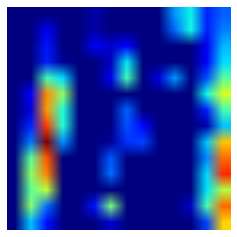

In [116]:
plt.imshow(test_feat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

In [117]:
files, all_feats = fe.extract10()

on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-4.
took 5.20263004303 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-7.jpeg
took 4.91868591309 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher3-3.jpeg
took 4.87297511101 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher3-7.jpeg
took 4.82712197304 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/6bd6b966cc82eb0a9b97ca39bb04d679c95370ec.jpg
took 4.82378005981 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-0.jpeg
took 4.83662486076 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-1.jpeg
took 4.84098219872 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-4.jpeg
took 4.

In [118]:
len(files)

10

In [119]:
sys.getsizeof(all_feats)/1000000000.

0.20552104

In [120]:
files

[u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-4.',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher1-7.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher3-3.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Affenpinscher/Affenpinscher3-7.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/6bd6b966cc82eb0a9b97ca39bb04d679c95370ec.jpg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-0.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-1.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound1-4.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound3-0.jpeg',
 u'/media/nate/Windows/github/IDmyDog/scrape_ims/images/Afghan Hound/Afghan Hound4-5.jpeg']

In [121]:
files2, all_feats2 = fe.extract10()

on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/4e25aacc9714996aeeadbb7d065d38d2850c478b.jpg
took 4.8741710186 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/Airedale Terrier1-0.jpeg
took 5.166670084 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/Airedale Terrier1-2.jpeg
took 4.97763895988 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/Airedale Terrier1-4.jpeg
took 4.91325712204 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/Airedale Terrier1-5.jpeg
took 4.97001695633 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Airedale Terrier/Airedale Terrier3-8.jpeg
took 5.00331783295 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape_ims/images/Akita/9f806755bff025e79bf259c001bf4cde294f71fb.jpg
took 4.9402718544 seconds
on image: /media/nate/Windows/github/IDmyDog/scrape

In [122]:
sys.getsizeof(all_feats2)

205521040

In [ ]:
files3, all_feats3 = fe.extract10()